In [1]:
import os
import pandas as pd
import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


In [23]:
_img_width = 178
_img_height = 218

In [24]:
test_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

test_generator = test_datagen.flow_from_directory(
    './img',
    classes=['to_label2'],
    batch_size=1,
    target_size=(_img_width, _img_height),
    shuffle=False)

Found 256000 images belonging to 1 classes.


In [25]:
base_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(_img_width, _img_height, 3))

print("number of layers:", len(base_model.layers))

for layer in base_model.layers[:52]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

number of layers: 311


In [26]:
model.load_weights('inception_v3_eyeglasses.h5')

In [27]:
model_predictions = model.predict(test_generator)

In [54]:
model_predictions[11]

array([0.99715877], dtype=float32)

In [33]:
with h5py.File('sample_z2.h5', 'r') as f:
    z = f['z'][:]

In [2]:
from custom_gen import StyleGANGenerator
_stylegan_ffhq_f_gdrive_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl'

gen = StyleGANGenerator(_stylegan_ffhq_f_gdrive_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Failed!


RuntimeError: NVCC returned an error. See below for full command line and output log:

nvcc "/home/rbelanec/anaconda3/envs/BP/lib/python3.7/site-packages/tensorflow_core/python/_pywrap_tensorflow_internal.so" --compiler-options '-fPIC -D_GLIBCXX_USE_CXX11_ABI=1' --gpu-architecture=sm_61 --use_fast_math --disable-warnings --include-path "/home/rbelanec/anaconda3/envs/BP/lib/python3.7/site-packages/tensorflow_core/include" --include-path "/home/rbelanec/anaconda3/envs/BP/lib/python3.7/site-packages/tensorflow_core/include/external/protobuf_archive/src" --include-path "/home/rbelanec/anaconda3/envs/BP/lib/python3.7/site-packages/tensorflow_core/include/external/com_google_absl" --include-path "/home/rbelanec/anaconda3/envs/BP/lib/python3.7/site-packages/tensorflow_core/include/external/eigen_archive" 2>&1 "/home/rbelanec/Documents/BP/stylegan2/dnnlib/tflib/ops/fused_bias_act.cu" --shared -o "/tmp/tmpokc_yhmr/fused_bias_act_tmp.so" --keep --keep-dir "/tmp/tmpokc_yhmr"

/usr/include/c++/10/chrono: In substitution of ‘template<class _Rep, class _Period> template<class _Period2> using __is_harmonic = std::__bool_constant<(std::ratio<((_Period2::num / std::chrono::duration<_Rep, _Period>::_S_gcd(_Period2::num, _Period::num)) * (_Period::den / std::chrono::duration<_Rep, _Period>::_S_gcd(_Period2::den, _Period::den))), ((_Period2::den / std::chrono::duration<_Rep, _Period>::_S_gcd(_Period2::den, _Period::den)) * (_Period::num / std::chrono::duration<_Rep, _Period>::_S_gcd(_Period2::num, _Period::num)))>::den == 1)> [with _Period2 = _Period2; _Rep = _Rep; _Period = _Period]’:
/usr/include/c++/10/chrono:473:154:   required from here
/usr/include/c++/10/chrono:428:27: internal compiler error: Segmentation fault
  428 |  _S_gcd(intmax_t __m, intmax_t __n) noexcept
      |                           ^~~~~~
Please submit a full bug report,
with preprocessed source if appropriate.
See <http://bugzilla.redhat.com/bugzilla> for instructions.
Preprocessed source stored into /tmp/cce2yFV9.out file, please attach this to your bugreport.


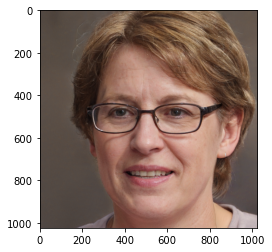

In [35]:
img = gen.get_images(np.reshape(z[11], (1,512)))
plt.imshow(img[0]/255)

In [51]:
import feature_axis.axis as axis
feature_slope = axis.find_feature_axis(z, model_predictions, method='tanh')

In [52]:
_normalize_feature_direction = True

if _normalize_feature_direction:
    feature_direction = axis.normalize_feature_axis(feature_slope)
else:
    feature_direction = feature_slope

In [53]:
feature_direction_file = 'feature_direction_eyeglasses_tanh_normalized.pkl'
dict_to_save = {'direction': feature_direction, 'name': 'Eyeglasses'}
with open(feature_direction_file, 'wb') as f:
    pickle.dump(dict_to_save, f)

In [55]:
with open('predictions_eyeglasses_inceptionv3.pkl', 'wb') as f:
    pickle.dump(model_predictions, f)

In [56]:
with open('predictions_eyeglasses_inceptionv3.pkl', 'rb') as f:
    new = pickle.load(f)

In [58]:
new[11]

array([0.99715877], dtype=float32)